In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [5]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [6]:
class DeepONet():
    def __init__(self, X, y, branch_layer, trunk_layer, y_d, lr, activation):
        self.y_d = y_d
        self.Um  = X[:, :-y_d]
        self.y   = X[:, -y_d:]
        self.Guy_true = y
        self.activation = activation
        self.loss_log = []

        self.branch_layer = branch_layer
        self.trunk_layer  = trunk_layer

        self.sess = tf.Session()
        self.branch_weights, self.branch_biases = self.initilize_NN(branch_layer)
        self.trunk_weights, self.trunk_biases = self.initilize_NN(trunk_layer)
        self.bias = tf.Variable(tf.zeros([1], dtype=tf.float32), dtype=tf.float32)

        self.x_tf   = tf.placeholder(tf.float32, shape=[None, self.Um.shape[1]])
        self.y_tf   = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.Guy_tf = tf.placeholder(tf.float32, shape=[None, self.Guy_true.shape[1]])

        self.branch_out = self.neural_net(self.x_tf, self.branch_weights, self.branch_biases, self.activation)
        self.trunk_out  = self.neural_net(self.y_tf, self.trunk_weights, self.trunk_biases, self.activation)
        self.Guy_pred = tf.reshape(tf.reduce_sum(tf.multiply(self.branch_out, self.trunk_out), axis=1) + self.bias, [-1, 1])

        self.loss = tf.reduce_mean(tf.square(self.Guy_pred - self.Guy_tf))
        #self.loss = tf.sqrt(tf.reduce_sum(tf.square(self.Guy_pred - self.Guy_tf)))

        self.u = self.residual_net(self.y_tf)
        ## 指数衰减学习率
        steps_per_decay = 1000
        decay_factor = 0.9
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(learning_rate = lr,
                                           global_step = self.global_step,
                                           decay_steps = steps_per_decay,
                                           decay_rate = decay_factor,
                                           staircase = True
                                           )
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss, global_step=self.global_step)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def callback(self, loss):
        print('Loss:', loss)

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def get_batch(self, batch_size):
        index = np.random.randint(0, self.y.shape[0], batch_size)
        return self.Um[index, :], self.y[index, :], self.Guy_true[index, :]

    def train(self, max_iter=40000, batch_size=50):
        loss_value = np.inf
        for iter in range(max_iter):
            self.sess.run(self.global_step)
            X, y, Guy_true = self.get_batch(batch_size)
            tf_dict = {
                self.x_tf : X,
                self.y_tf : y,
                self.Guy_tf : Guy_true
            }
            _, loss_value = self.sess.run([self.optimizer, self.loss], tf_dict)
            self.loss_log.append(loss_value)
            self.sess.run(self.lr)
            if iter % 100 == 0:
                print("第%d次的损失为%f"%(iter, loss_value))
        print("第%d次的损失为%f"%(max_iter, loss_value))
        print("最终lr为%f"%(self.sess.run(self.lr)))

    def predict(self, X_test):
        Guy_test = self.sess.run(self.Guy_pred, {self.x_tf: X_test[:, :-self.y_d], self.y_tf:X_test[:, -self.y_d:]})
        return Guy_test

    def residual_net(self, y):
        u = tf.gradients(self.Guy_pred, y)[0]
        return u

    def predict_u(self, X_test):
        u = self.sess.run(self.u, {self.x_tf: X_test[:, :-self.y_d], self.y_tf:X_test[:, -self.y_d:]})
        return u

In [7]:
# hyper params
sensors = 100
random_y = 100
y_d = 1
s0      = 0   # initial
p       = 50
branch_layers = [100, 100, 100]
trunk_layers =  [1, 100, 100]

In [8]:
# dataset
x_train = np.load("./dataset/SifanWang/DeepONet/x_train.npy")
y_train = np.load("./dataset/SifanWang/DeepONet/y_train.npy")

In [9]:
lr = 1e-3
activation = tf.tanh # tanh效果不好，loss始终是10-3
model = DeepONet(x_train, y_train, branch_layers, trunk_layers, y_d, lr, activation)

In [10]:
# train
start_time = time.time()
model.train(max_iter=40000, batch_size=10000)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

第0次的损失为0.199160
第100次的损失为0.009813
第200次的损失为0.009121
第300次的损失为0.009002
第400次的损失为0.009083
第500次的损失为0.008885
第600次的损失为0.008291
第700次的损失为0.008186
第800次的损失为0.007843
第900次的损失为0.007516
第1000次的损失为0.007088
第1100次的损失为0.006688
第1200次的损失为0.006690
第1300次的损失为0.006011
第1400次的损失为0.008037
第1500次的损失为0.005626
第1600次的损失为0.004154
第1700次的损失为0.004619
第1800次的损失为0.005004
第1900次的损失为0.003410
第2000次的损失为0.003340
第2100次的损失为0.007379
第2200次的损失为0.005787
第2300次的损失为0.003615
第2400次的损失为0.002902
第2500次的损失为0.003600
第2600次的损失为0.002955
第2700次的损失为0.003122
第2800次的损失为0.002781
第2900次的损失为0.003094
第3000次的损失为0.002852
第3100次的损失为0.002814
第3200次的损失为0.003131
第3300次的损失为0.003053
第3400次的损失为0.003106
第3500次的损失为0.002622
第3600次的损失为0.002741
第3700次的损失为0.002583
第3800次的损失为0.002564
第3900次的损失为0.002713
第4000次的损失为0.002501
第4100次的损失为0.002564
第4200次的损失为0.003272
第4300次的损失为0.002591
第4400次的损失为0.002512
第4500次的损失为0.003735
第4600次的损失为0.002720
第4700次的损失为0.003104
第4800次的损失为0.002525
第4900次的损失为0.002630
第5000次的损失为0.002561
第5100次的损失为0.002709
第5200次的损失为0.002437
第5300

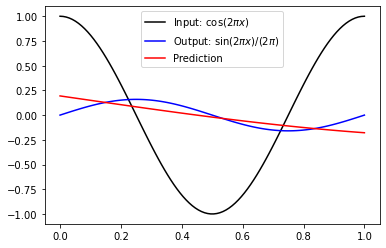

In [11]:
# visualize
def plot(sensors, net):
    x = np.linspace(0, 1, num=sensors)
    y = np.linspace(0, 1, num=sensors)
    cos = np.cos(2 * np.pi * x)
    antide_true = np.sin(2 * np.pi * y) / (2 * np.pi)
    antide_pred = net.predict(np.hstack([np.tile(cos, (len(y), 1)), y[:, None]])).squeeze()

    plt.plot(x, cos, color='black', label=r'Input: $\cos(2\pi x)$', zorder=0)
    plt.plot(y, antide_true, color='b', label=r'Output: $\sin(2\pi x)/(2\pi)$', zorder=1)
    plt.plot(y, antide_pred, color='r', label=r'Prediction', zorder=2)
    plt.legend()
    plt.savefig('deeponet_adam.pdf')
plot(sensors, model)

In [12]:
def plot_loss(model, start, end):
    iter = np.linspace(start, end, end - start)
    plt.plot(iter, np.array(model.loss_log)[start:end])
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('loss.pdf')

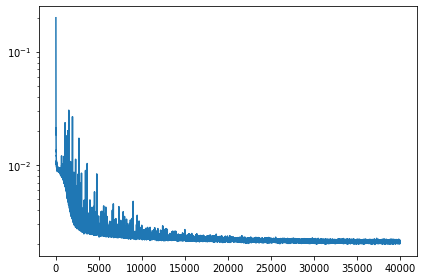

In [13]:
plot_loss(model, 0, 40000)

In [14]:
# relative L2 norm
y_pred = model.predict(x_train)
error_s = np.linalg.norm(y_train - y_pred) / np.linalg.norm(y_train)
print(error_s)
u = np.load("./dataset/SifanWang/u_test.npy")
y = np.load("./dataset/SifanWang/y_test.npy")
s = np.load("./dataset/SifanWang/s_test.npy")
error = []
for i in range(u.shape[0]):
    y_pred = model.predict(np.hstack((u[i], y[i])))
    error.append(np.linalg.norm(y_pred - s[i])/np.linalg.norm(s[i]))
error = np.array(error)
print(error.mean())
print(error.std())

0.10791226
0.19654019
0.1558037


In [123]:
## 求解Burgers' Equation
import scipy.io
data = scipy.io.loadmat('./Burgers/burgers_shock.mat')
x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
Exact =np.real(data['usol']).T

In [124]:
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]
# 初始点
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
# x=-1的边界点
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
# x=1的边界点
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]
xbc = np.vstack((xx1, xx2, xx3))
ubc = np.vstack((uu1, uu2, uu3))

In [125]:
# t = 0.25
xx25 = np.hstack((X[25:26, :].T, T[25:26, :].T))
uu25 = Exact[25:26, :].T
# t = 0.50
xx50 = np.hstack((X[50:51, :].T, T[50:51, :].T))
uu50 = Exact[50:51, :].T
# t = 0.75
xx75 = np.hstack((X[75:76, :].T, T[75:76, :].T))
uu75 = Exact[75:76, :].T

In [126]:
sensors  = 256
y_d      = 2
random_y = xx1.shape[0]
p        = 100
branch_layer = [sensors, 100, 100, 100, 100, 100, 100, p]
trunk_layer =  [2, 100, 100, 100, 100, 100, 100, p]

In [127]:
idu = np.random.choice(xbc.shape[0], sensors, replace=False)
xbci = xbc[idu]
ubci = ubc[idu]

In [128]:
Exact_list = [uu25, uu50, uu75]
X_list = [xx25, xx50, xx75]
Guy_ = []
input_y = []
for i in range(len(Exact_list)):
    idx = np.random.choice(X_list[i].shape[0], random_y, replace=False)
    y = X_list[i][idx]
    input_y.append(y)
    Guy_.append(Exact_list[i][idx])
y_train = np.array(Guy_).reshape(-1, 1)

In [129]:
input_u = []
for i in range(len(X_list)):
    input_u.append(np.hstack([np.tile(ubci.reshape(-1, sensors), (random_y, 1)), input_y[i]]))
x_train = np.array(input_u).reshape(-1, sensors+y_d)

In [131]:
lr = 1e-3
deepONet = DeepONet(x_train, y_train, branch_layer, trunk_layer, 2, lr, activation=tf.nn.relu)

In [132]:
start_time = time.time()
deepONet.train(max_iter=40000, batch_size=y_train.shape[0])
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

第0次的损失为0.397472
第100次的损失为0.003772
第200次的损失为0.001791
第300次的损失为0.002116
第400次的损失为0.000173
第500次的损失为0.000134
第600次的损失为0.000205
第700次的损失为0.000016
第800次的损失为0.000121
第900次的损失为0.000222
第1000次的损失为0.000041
第1100次的损失为0.000002
第1200次的损失为0.000001
第1300次的损失为0.000006
第1400次的损失为0.000006
第1500次的损失为0.000057
第1600次的损失为0.001214
第1700次的损失为0.000009
第1800次的损失为0.000001
第1900次的损失为0.000001
第2000次的损失为0.000000
第2100次的损失为0.000000
第2200次的损失为0.000001
第2300次的损失为0.000009
第2400次的损失为0.000004
第2500次的损失为0.000223
第2600次的损失为0.000071
第2700次的损失为0.000048
第2800次的损失为0.000021
第2900次的损失为0.000070
第3000次的损失为0.000014
第3100次的损失为0.000000
第3200次的损失为0.000001
第3300次的损失为0.000015
第3400次的损失为0.000001
第3500次的损失为0.000467
第3600次的损失为0.000766
第3700次的损失为0.000149
第3800次的损失为0.000001
第3900次的损失为0.000001
第4000次的损失为0.000001
第4100次的损失为0.000001
第4200次的损失为0.000000
第4300次的损失为0.000000
第4400次的损失为0.000000
第4500次的损失为0.000000
第4600次的损失为0.000000
第4700次的损失为0.000004
第4800次的损失为0.000023
第4900次的损失为0.000002
第5000次的损失为0.000157
第5100次的损失为0.000003
第5200次的损失为0.000001
第5300

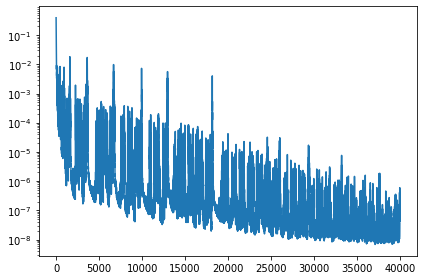

In [140]:
plot_loss(deepONet, 0, 40000)

In [134]:
def get_burgers(t, X, T, Exact, random_y, uu1, net):
    xx = np.hstack((X[t:t+1, :].T, T[t:t+1, :].T))
    uu = Exact[t:t+1, :].T
    idx = np.random.choice(xx.shape[0], random_y, replace=False)
    y = xx[idx]
    y_test = uu[idx]
    x_test = np.hstack([np.tile(uu1.reshape(1, -1), (random_y, 1)), y])
    y_pred = net.predict(x_test)
    # return np.sqrt(np.sum(np.square(y_pred - y_test)))
    return np.linalg.norm(y_pred - y_test) / np.linalg.norm(y_test)

In [135]:
get_burgers(90, X, T, Exact, random_y, ubci, deepONet)

0.03433667987382476

In [136]:
s = 0
for i in range(100):
    s += get_burgers(i, X, T, Exact, random_y, ubci, deepONet)
print(s / 100)

0.051473030519636975


第0次的损失为0.346280
第100次的损失为0.027170
第200次的损失为0.022841
第300次的损失为0.019083
第400次的损失为0.016469
第500次的损失为0.009262
第600次的损失为0.009215
第700次的损失为0.006144
第800次的损失为0.006828
第900次的损失为0.006149
第1000次的损失为0.004912
第1100次的损失为0.006561
第1200次的损失为0.004840
第1300次的损失为0.003472
第1400次的损失为0.003868
第1500次的损失为0.002201
第1600次的损失为0.004330
第1700次的损失为5.160354
第1800次的损失为0.013785
第1900次的损失为0.007929
第2000次的损失为0.011537
第2100次的损失为0.006418
第2200次的损失为0.007044
第2300次的损失为0.005561
第2400次的损失为0.005487
第2500次的损失为0.006265
第2600次的损失为0.008547
第2700次的损失为0.005669
第2800次的损失为0.003945
第2900次的损失为0.003076
第3000次的损失为0.005799
第3100次的损失为0.003843
第3200次的损失为0.004072
第3300次的损失为0.002550
第3400次的损失为0.003972
第3500次的损失为0.002044
第3600次的损失为0.002154
第3700次的损失为0.002420
第3800次的损失为0.001347
第3900次的损失为0.001012
第4000次的损失为0.001368
第4100次的损失为0.000666
第4200次的损失为0.001544
第4300次的损失为0.000536
第4400次的损失为0.000281
第4500次的损失为0.001481
第4600次的损失为0.000295
第4700次的损失为0.000279
第4800次的损失为0.000592
第4900次的损失为0.000128
第5000次的损失为0.000185
第5100次的损失为0.000225
第5200次的损失为0.000149
第5300

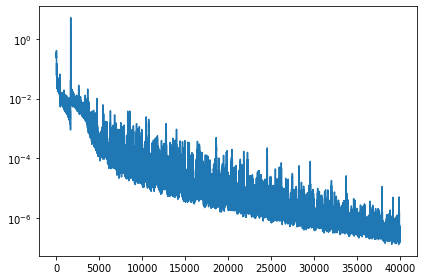

In [141]:
deepONet_tanh = DeepONet(x_train, y_train, branch_layer, trunk_layer, 2, lr, activation=tf.tanh)
start_time = time.time()
deepONet_tanh.train(max_iter=40000, batch_size=y_train.shape[0])
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
plot_loss(deepONet_tanh, 0, 40000)


In [142]:
s = 0
for i in range(100):
    s += get_burgers(i, X, T, Exact, random_y, ubci, deepONet_tanh)
print(s / 100)


0.1008397703322935
